# Dropsonde Based Surface Evaporation per flight

This routine calculates the surface evaporation from the dropsondes over sea surface. The formula relies on Howland et al. (1983,https://doi.org/10.1175/1520-0493(1983)111<2255:TMBOTN>2.0.CO;2 )

E=C_d*rho_a*(q_s-q_a)*v --> (actually this formula comes from Rao et al. (1981))

C_d   : drag coefficient( 1.4e-3 for v< 13 m/s, 1.6e-3 for v>13m/s)
rho_a : air density at sea level
q_s   : saturation specific humidity
q_a   : actual specific humidity

## Configuration

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Predefinitions

In [6]:
campaign="HALO_AC3"
ar_of_day="AR_entire_2"
calibrated_hamp=True
flight=["RF06"]
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sector_to_plot="warm"

scalar_based_div=False
take_arbitary=False
do_plotting=True
plot_path=start_path+"/../plots/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)


### Flight pattern segments

In [7]:
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]
#if flight[0]=="RF16":
#    if ar_of_day=="AR_entire_1":
#            inflow_times=["2022-04-10 10:40","2022-04-10 11:08"]
#            internal_times=["2022-04-10 11:10","2022-04-10 11:36"]
#            outflow_times=["2022-04-10 11:57","2022-04-10 12:15"]
#    elif ar_of_day=="AR_entire_2":
#            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
#            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
#            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

## Prepare Dropsonde Data

In [8]:
Budget_cls = Budgets.Moisture_Budgets()
Evap_cls   = Budgets.Surface_Evaporation("HALO_AC3",flight,major_work_path,flight_dates={},
                sector_types=["warm","core","cold"],
                ar_of_day=ar_of_day,grid_name="ERA5",
                do_instantan=False)

with HiddenPrints():
    Evap_cls.prepare_dropsonde_data()
#Evap_cls.sonde_times_series

In [9]:
Evap_cls.Dropsondes
halo_df=Evap_cls.halo_df
#if inflow_times[-1]<outflow_times[0]:
new_halo_dict={"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
               "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
               "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}

In [10]:
sonde_times_series=pd.Series(index=Evap_cls.Dropsondes["IWV"].index.values,data=range(Evap_cls.Dropsondes["IWV"].shape[0]))

### Relevant Dropsondes

In [23]:
relevant_sondes_dict={}
internal_sondes_dict={}
if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_warm_internal_sondes=[7,8,13,14]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            #relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            synthetic_sonde_times_series=pd.Series(data=["7synth","8synth","9synth"],
                                     index=pd.DatetimeIndex(["2022-03-15 12:55","2022-03-15 13:05","2022-03-15 13:15"]))
            relevant_sondes_dict["cold_sector"]["out"] = synthetic_sonde_times_series
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
            internal_sondes_dict["cold"]               = ["2022-03-15 11:30:00","2022-03-15 13:35"]   
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_warm_internal_sondes=[13,14,22,23]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
elif flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,8,9,10]
            relevant_cold_sector_sondes=[3,4,5,11,12]
            relevant_warm_internal_sondes=[7,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3:]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3:]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[8,9,16,17]
            relevant_cold_sector_sondes=[10,11,12,18,19]
            relevant_warm_internal_sondes=[14,15,21,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:2]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[2::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]

In [24]:
internal_sondes_dict["warm"]

2022-03-16 13:22:31    14
2022-03-16 13:33:13    15
2022-03-16 14:46:46    21
2022-03-16 17:22:12    22
dtype: int64

In [32]:
new_halo_dict["inflow"].index=pd.DatetimeIndex(new_halo_dict["inflow"].index)
new_halo_dict["inflow"].index
inflow_warm_halo=new_halo_dict["inflow"].loc[relevant_sondes_dict["warm_sector"]["in"].index[0]:
                                          relevant_sondes_dict["warm_sector"]["in"].index[-1]]
western_lon=float(inflow_warm_halo.longitude.min())
if flight[0]=="RF06" and ar_of_day=="AR_entire_2":
    western_lon-=5

warm_internal_halo=new_halo_dict["internal"][new_halo_dict["internal"]["longitude"]>western_lon]
warm_internal_halo

,alt,latitude,longitude,groundspeed,Hour,Minutes,Minutesofday,distance
time,,,,,,,,
2022-03-16 13:15:26,12153.631836,74.561360,13.003767,262.101257,13,15,795,9.055883e+05
2022-03-16 13:15:27,12153.980469,74.562235,13.011930,262.135071,13,15,795,9.058504e+05
2022-03-16 13:15:28,12154.319336,74.563110,13.020097,262.170685,13,15,795,9.061126e+05
2022-03-16 13:15:29,12154.556641,74.563984,13.028266,262.211090,13,15,795,9.063748e+05
2022-03-16 13:15:30,12154.664062,74.564858,13.036439,262.256958,13,15,795,9.066371e+05
...,...,...,...,...,...,...,...,...
2022-03-16 13:40:55,12230.951172,75.535699,26.394828,263.717560,13,40,820,1.306513e+06
2022-03-16 13:40:56,12231.017578,75.537028,26.402625,263.847839,13,40,820,1.306776e+06
2022-03-16 13:40:57,12231.015625,75.538380,26.410366,263.977356,13,40,820,1.307040e+06


In [33]:
Evap_cls.calc_evaporation()

Rho_unc 0.004832439829091883
Shum_unc 0.00039999999999999937
Wind_unc 0.14142135623730956
Qsat_unc 0.000335500115288869


In [34]:
#Evap_cls.surface_data["Evap"]
evap_mm_h=Evap_cls.surface_data["Evap"]/997*3600*1000
#evap_mm_h.dropna()
Evap_cls.evap_mm_h=evap_mm_h
evap_mm_h

2022-03-16 10:46:57         NaN
2022-03-16 10:56:15         NaN
2022-03-16 11:03:35         NaN
2022-03-16 11:14:00         NaN
2022-03-16 11:21:25         NaN
2022-03-16 11:28:35         NaN
2022-03-16 11:39:17         NaN
2022-03-16 11:51:59         NaN
2022-03-16 12:13:00    0.064122
2022-03-16 12:21:11    0.099930
2022-03-16 12:35:11    0.067046
2022-03-16 12:41:23    0.035284
2022-03-16 12:48:51    0.065775
2022-03-16 13:11:55    0.054328
2022-03-16 13:22:31    0.089814
2022-03-16 13:33:13         NaN
2022-03-16 13:48:06   -0.019815
2022-03-16 13:58:21   -0.050251
2022-03-16 14:07:17   -0.001392
2022-03-16 14:16:19    0.105377
2022-03-16 14:27:28         NaN
2022-03-16 14:46:46         NaN
2022-03-16 17:22:12         NaN
Name: Evap, dtype: float64

In [35]:
evap_mm_h_unc=Evap_cls.surface_data["Evap_unc"]/997*3600*1000
evap_mm_h_unc.dropna()
Evap_cls.evap_mm_h_unc=evap_mm_h_unc
evap_mm_h_unc

2022-03-16 10:46:57         NaN
2022-03-16 10:56:15         NaN
2022-03-16 11:03:35         NaN
2022-03-16 11:14:00         NaN
2022-03-16 11:21:25         NaN
2022-03-16 11:28:35         NaN
2022-03-16 11:39:17         NaN
2022-03-16 11:51:59         NaN
2022-03-16 12:13:00    0.043718
2022-03-16 12:21:11    0.070009
2022-03-16 12:35:11    0.032598
2022-03-16 12:41:23    0.034236
2022-03-16 12:48:51    0.036903
2022-03-16 13:11:55    0.034760
2022-03-16 13:22:31    0.052798
2022-03-16 13:33:13         NaN
2022-03-16 13:48:06   -0.037674
2022-03-16 13:58:21   -0.046864
2022-03-16 14:07:17   -0.032016
2022-03-16 14:16:19    0.040871
2022-03-16 14:27:28         NaN
2022-03-16 14:46:46         NaN
2022-03-16 17:22:12         NaN
Name: Evap_unc, dtype: float64

## Surface Evaporation Quicklook

In [36]:
Evap_cls.cmpgn_cls.plot_path=plot_path
import Airborne_Budget_Plots as Airplots
haloac3_budget_plots = Airplots.HALO_AC3_Budget_Plots(Evap_cls.cmpgn_cls,flight,ar_of_day)
haloac3_evaporation  = Airplots.HALO_AC3_evaporation(Evap_cls.cmpgn_cls,flight,ar_of_day,halo_df)

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/


Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots//supplements/Sonde_Evap_RF06_AR_entire_2.png


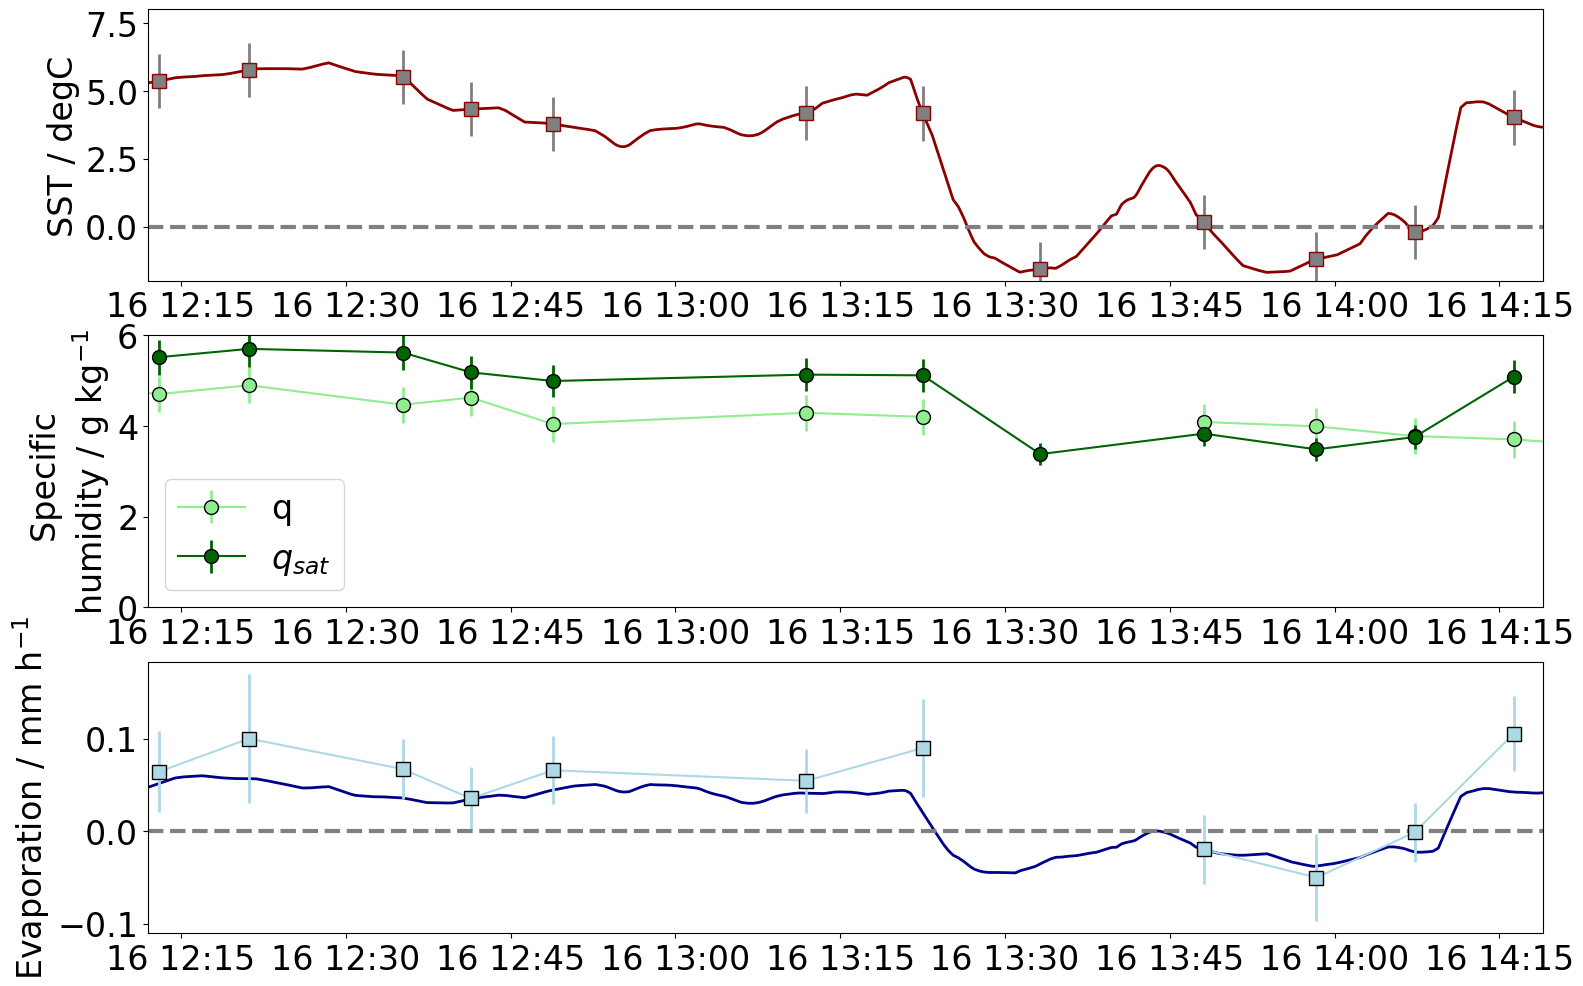

In [37]:
haloac3_evaporation.plot_quantities_quicklook(Evap_cls)

## Manuscript Figure

if flight is RF05 and AR entire_1 then it creates the manuscript plot (fig.08) otherwise it is a supplement illustrating the others

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots//supplements/Sonde_Evap_RF06_S4.png


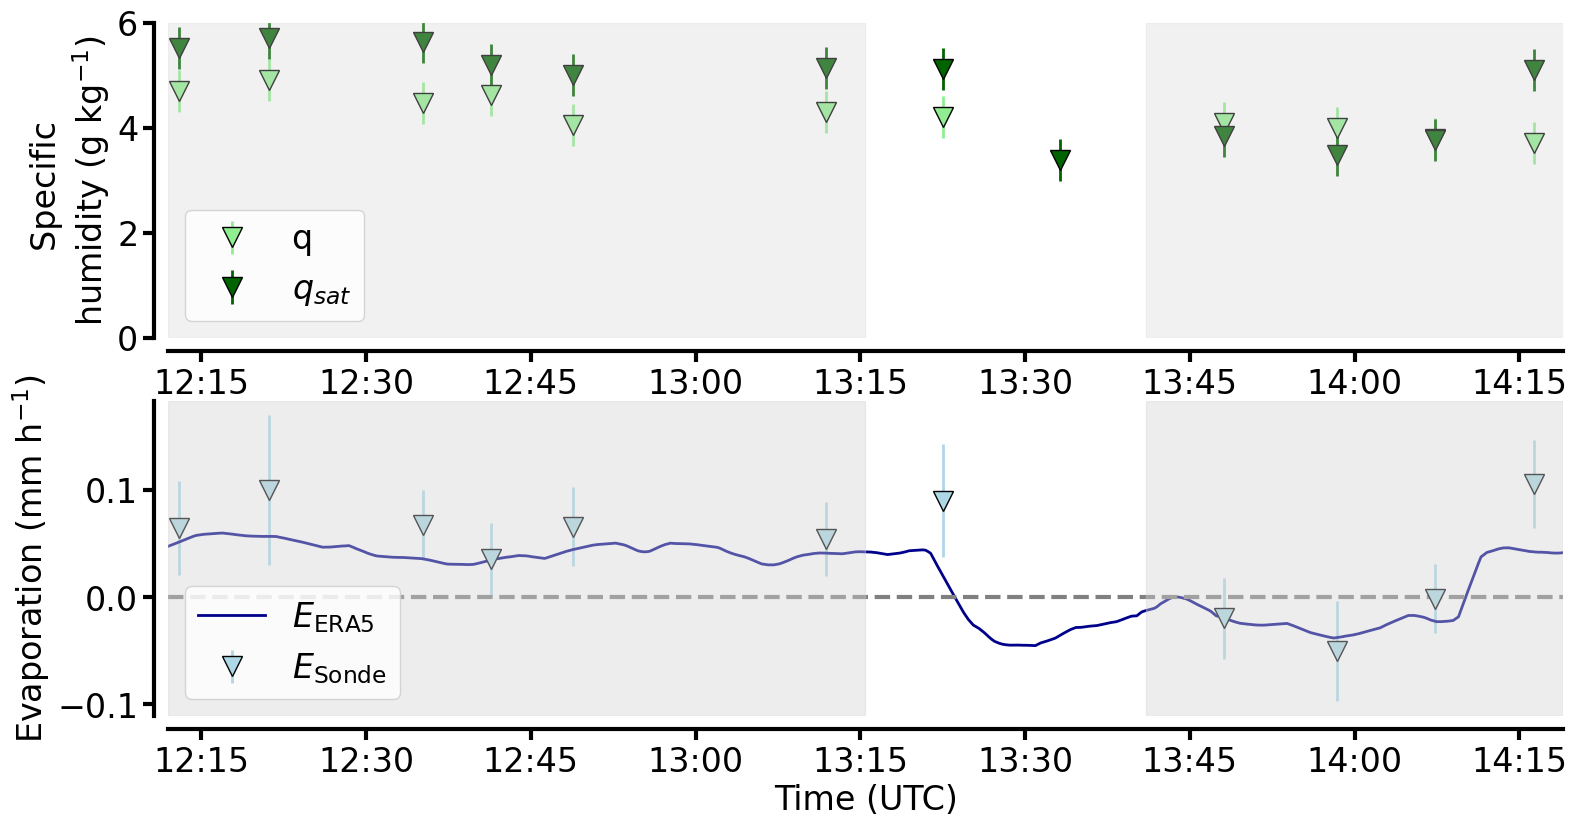

In [38]:
haloac3_evaporation.plot_evap_internal(Evap_cls,warm_internal_halo)

#### Calc internal average

In [39]:
internal_mean_evap=haloac3_evaporation.Evap_cls.evap_mm_h.loc[warm_internal_halo.index[0]:warm_internal_halo.index[-1]].mean()
internal_mean_evap_unc=abs(haloac3_evaporation.Evap_cls.evap_mm_h_unc.loc[warm_internal_halo.index[0]:warm_internal_halo.index[-1]]).mean()
print(flight[0]," "+ar_of_day,"internal_mean_evap:",internal_mean_evap,"+/-",internal_mean_evap_unc)

RF06  AR_entire_2 internal_mean_evap: 0.08981358901146912 +/- 0.05279755779212409


### Save in budget dataframe

In [40]:
evap_series=pd.Series(data=[internal_mean_evap,internal_mean_evap_unc],index=["Evap","Evap_unc"])
haloac3_budget_plots.change_values_in_budget_df(evap_series)

Evap        0.089814
Evap_unc    0.052798
dtype: float64
            IWV_dt  IWV_dt_unc  ADV_q  ADV_q_unc  DIV_mass  DIV_mass_unc  \
Unnamed: 0                                                                 
S1             NaN         NaN    NaN        NaN       NaN           NaN   
S2             NaN         NaN    NaN        NaN       NaN           NaN   
S3             NaN         NaN    NaN        NaN       NaN           NaN   
S4             NaN         NaN    NaN        NaN       NaN           NaN   

            Precip  Precip_unc      Evap  Evap_unc  
Unnamed: 0                                          
S1             NaN         NaN  0.007065  0.059248  
S2             NaN         NaN -0.006380  0.062227  
S3             NaN         NaN  0.056166  0.061512  
S4             NaN         NaN  0.089814  0.052798  
budget df saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/

In [41]:
haloac3_budget_plots.budget_df

,IWV_dt,IWV_dt_unc,ADV_q,ADV_q_unc,DIV_mass,DIV_mass_unc,Precip,Precip_unc,Evap,Evap_unc
Unnamed: 0,,,,,,,,,,
S1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007065,0.059248
S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006380,0.062227
S3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056166,0.061512
S4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089814,0.052798
